<h1><center>Attempt to implement ResNet-50 model</center></h1>

This notebook is the first attempt to implement ResNet-50 for classification purpose as Deep Neural Network technique. Its an attempt to explain and understant the model better.



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
#to be done once only 
!unzip -uq "/content/drive/My Drive/Datasets/10-monkey-species.zip" -d "/content/drive/My Drive/Unzipped_Dataset/monkeys"

In [ ]:
import os
root_dir = "/content/drive/My Drive/Unzipped_Dataset/monkeys/training/training"
val_dir = "/content/drive/My Drive/Unzipped_Dataset/monkeys/validation/validation"
different_species = os.listdir(root_dir)
print([species for species in different_species])

['n0', 'n1', 'n2', 'n3', 'n4', 'n5', 'n6', 'n7', 'n8', 'n9']


In [ ]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
import cv2
import numpy as np
from keras import layers
from keras.applications.resnet50 import ResNet50, preprocess_input
from keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, Dropout, UpSampling2D, Flatten
from keras.models import Model, load_model
from keras.initializers import glorot_uniform
from keras.utils import plot_model
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
import keras.backend as K
import tensorflow as tf
from keras_preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam, SGD

Reizing all the images and saving them

In [ ]:
length = 224
width = 224
channels = 3
n_classes = 10
dim = (224, 224)
EPOCHS = 15

In [ ]:
different_species = os.listdir(root_dir)
#Resizing and saving all the images
for species in different_species:
  dir_ = os.path.join(root_dir, species)
  images = os.listdir(dir_)
  print('Resizing the training images for class {}'.format(species))
  print('Number of samples for class {} is  {}'.format(species, len(images)))
  for image in images:
    #print(image)
    if image == 'n9151jpg':
      os.remove(os.path.join(dir_, image))
    else:
      resized_img = cv2.imread(os.path.join(dir_, image))
      resized_img = cv2.resize(resized_img, dim, interpolation = cv2.INTER_AREA)
      cv2.imwrite(os.path.join(dir_, image), resized_img)

print('\n')
for species in different_species:
  dir_ = os.path.join(val_dir, species)
  images = os.listdir(dir_)
  print('Resizing the validation images for class {}'.format(species))
  print('Number of samples for class {} is  {}'.format(species, len(images)))
  for image in images:
    resized_img = cv2.imread(os.path.join(dir_, image))
    resized_img = cv2.resize(resized_img, dim, interpolation = cv2.INTER_AREA)
    cv2.imwrite(os.path.join(dir_, image), resized_img)

Resizing the training images for class n0
Number of samples for class n0 is  105
Resizing the training images for class n1
Number of samples for class n1 is  111
Resizing the training images for class n2
Number of samples for class n2 is  110
Resizing the training images for class n3
Number of samples for class n3 is  122
Resizing the training images for class n4
Number of samples for class n4 is  105
Resizing the training images for class n5
Number of samples for class n5 is  113
Resizing the training images for class n6
Number of samples for class n6 is  106
Resizing the training images for class n7
Number of samples for class n7 is  114
Resizing the training images for class n8
Number of samples for class n8 is  106
Resizing the training images for class n9
Number of samples for class n9 is  105


Resizing the validation images for class n0
Number of samples for class n0 is  26
Resizing the validation images for class n1
Number of samples for class n1 is  28
Resizing the validation 

In [ ]:
#Read in the data
datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
train_gen = datagen.flow_from_directory(root_dir, target_size=(224,224), batch_size=32, class_mode='categorical', shuffle = False, classes = different_species)

Found 1097 images belonging to 10 classes.


In [ ]:
val_gen = datagen.flow_from_directory(val_dir, target_size=(224,224), batch_size=32, class_mode='categorical', shuffle=False, classes = different_species)

Found 272 images belonging to 10 classes.


Defining the Indentity block

In [ ]:
def identity_block(X, f, filters, stage, block):
    # defining name basis
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'

    # Retrieve Filters
    F1, F2, F3 = filters

    # Save the input value. We'll need this later to add back to the main path. 
    X_shortcut = X

    # First component of main path
    X = Conv2D(filters = F1, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2a', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2a')(X)
    X = Activation('relu')(X)

    # Second component of main path
    X = Conv2D(filters = F2, kernel_size = (f, f), strides = (1,1), padding = 'same', name = conv_name_base + '2b', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2b')(X)
    X = Activation('relu')(X)

    # Third component of main path
    X = Conv2D(filters = F3, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2c', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2c')(X)

    # Final step: Add shortcut value to main path, and pass it through a RELU activation
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)

    return X

Defining the convolution block

In [ ]:
def convolutional_block(X, f, filters, stage, block, s = 2):
    # defining name basis
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    
    # Retrieve Filters
    F1, F2, F3 = filters
    
    # Save the input value
    X_shortcut = X


    ##### MAIN PATH #####
    # First component of main path 
    X = Conv2D(F1, (1, 1), strides = (s,s), name = conv_name_base + '2a', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2a')(X)
    X = Activation('relu')(X)

    # Second component of main path
    X = Conv2D(filters=F2, kernel_size=(f, f), strides=(1, 1), padding='same', name=conv_name_base + '2b', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2b')(X)
    X = Activation('relu')(X)

    # Third component of main path
    X = Conv2D(filters=F3, kernel_size=(1, 1), strides=(1, 1), padding='valid', name=conv_name_base + '2c', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2c')(X)

    
    ##### SHORTCUT PATH ####
    X_shortcut = Conv2D(F3, (1, 1), strides = (s,s), name = conv_name_base + '1', kernel_initializer = glorot_uniform(seed=0))(X_shortcut)
    X_shortcut = BatchNormalization(axis = 3, name = bn_name_base + '1')(X_shortcut)

    # Final step: Add shortcut value to main path, and pass it through a RELU activation
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)
    
    return X

Defining the model

In [ ]:
def ResNet(input_shape = (224, 224, 3), classes = 2):   
    # Define the input as a tensor with shape input_shape
    X_input = Input(input_shape)

    # Zero-Padding
    X = ZeroPadding2D((3, 3))(X_input)
    
    # Stage 1
    X = Conv2D(64, (7, 7), strides = (2, 2), name = 'conv1', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = 'bn_conv1')(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((3, 3), strides=(2, 2))(X)

    # Stage 2
    X = convolutional_block(X, f = 3, filters = [64, 64, 256], stage = 2, block='a', s = 1)
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='b')
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='c')

    # Stage 3
    X = convolutional_block(X, f = 3, filters = [128, 128, 512], stage = 3, block='a', s = 2)
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='b')
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='c')
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='d')

    # Stage 4
    X = convolutional_block(X, f = 3, filters = [128, 128, 512], stage = 5, block='a', s = 2)
    X = identity_block(X, 3, [128, 128, 512], stage=5, block='b')
    X = identity_block(X, 3, [128, 128, 512], stage=5, block='c')

    # AVGPOOL.
    X = AveragePooling2D((2, 2), name='avg_pool')(X)

    # output layer
    X = Flatten()(X)
    X = Dense(classes, activation='softmax', name='fc' + str(classes), kernel_initializer = glorot_uniform(seed=0))(X)
    
    # Create model
    model = Model(inputs = X_input, outputs = X, name='ResNet50')

    return model

In [ ]:
model = ResNet(input_shape = (length, width, channels), classes = n_classes)

In [ ]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "ResNet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
zero_padding2d_1 (ZeroPadding2D (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        zero_padding2d_1[0][0]           
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
___________________________________________________________________________________________

In [ ]:
model.fit_generator(generator = train_gen, steps_per_epoch= len(train_gen),
                    validation_data= val_gen,
                    validation_steps=len(val_gen),
                    epochs=20)

Epoch 1/20
22/22 [==============================] - 585s 27s/step - loss: 24.9273 - accuracy: 0.0966 - val_loss: 3.3807 - val_accuracy: 0.1029
Epoch 2/20
22/22 [==============================] - 513s 23s/step - loss: 4.7366 - accuracy: 0.0538 - val_loss: 39.8768 - val_accuracy: 0.1581
Epoch 3/20
22/22 [==============================] - 513s 23s/step - loss: 3.9841 - accuracy: 0.0611 - val_loss: 2.3104 - val_accuracy: 0.0809
Epoch 4/20
22/22 [==============================] - 512s 23s/step - loss: 3.1499 - accuracy: 0.0802 - val_loss: 2.2718 - val_accuracy: 0.1140
Epoch 5/20
22/22 [==============================] - 506s 23s/step - loss: 2.9887 - accuracy: 0.1021 - val_loss: 2.2861 - val_accuracy: 0.1103
Epoch 6/20
22/22 [==============================] - 498s 23s/step - loss: 2.9057 - accuracy: 0.0273 - val_loss: 4.8160 - val_accuracy: 0.1176
Epoch 7/20
22/22 [==============================] - 504s 23s/step - loss: 2.8859 - accuracy: 0.0456 - val_loss: 2.1436 - val_accuracy: 0.0993
Epoc

In [ ]:
model.save('ResNet_monkey.h5')

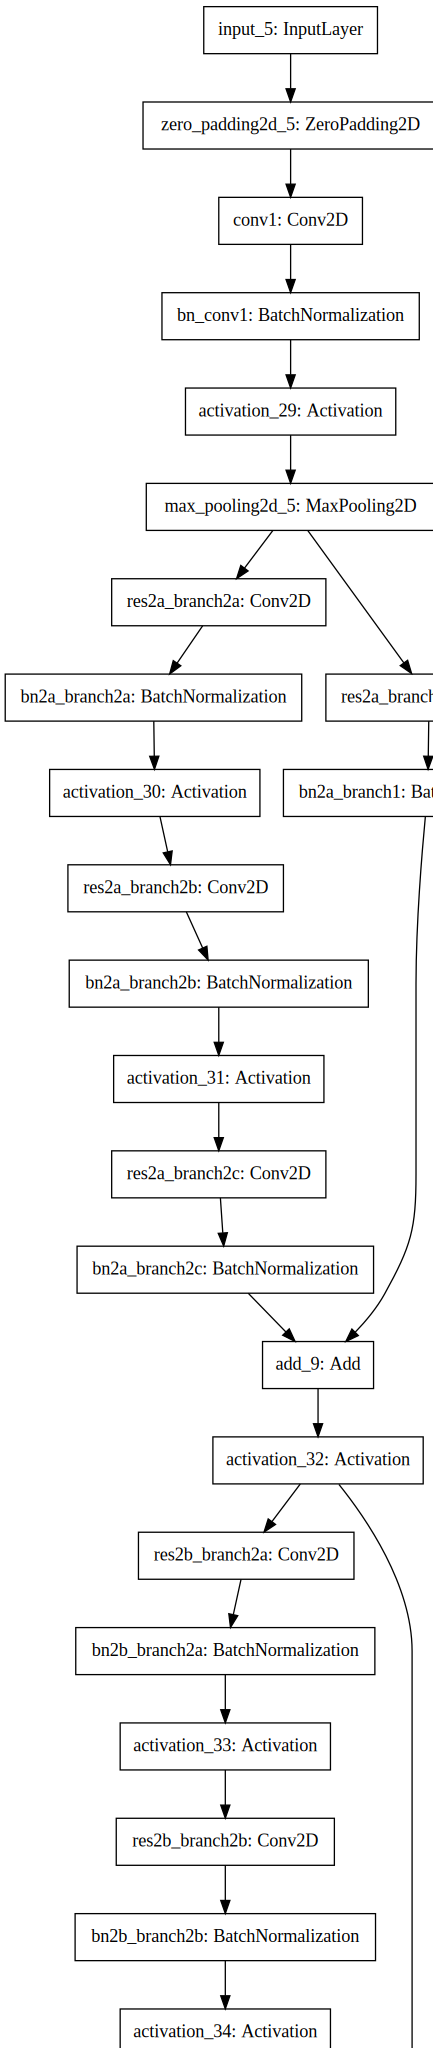

In [ ]:
plot_model(model, to_file='model.png')
SVG(model_to_dot(model).create(prog='dot', format='svg'))

Since the entire model takes too long to train all the parametres I will implement transfer learning to reduce the training time and achieve good result.

In [ ]:
from keras.callbacks import EarlyStopping, ModelCheckpoint
PATIENCE = 5
MODEL_CHECK_WEIGHT_NAME = 'resnet50_tl_monk_chk.h5'

In [ ]:
K.set_learning_phase(0)
#Uisng the input shape for the resnet50 model trained on image net
model = ResNet50(input_shape=(224,224,3),include_top=False, weights='imagenet', pooling='avg')
K.set_learning_phase(1)
x = model.output
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(512, activation='relu')(x) 
x = Dropout(0.5)(x)
#Having more weights because I have included dropout
output = Dense(n_classes, activation='softmax', name='custom_output')(x)
custom_resnet = Model(inputs=model.input, outputs = output)

for layer in model.layers:
    layer.trainable = False

custom_resnet.compile(Adam(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
custom_resnet.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_4[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
____________________________________________________________________________________________

In [ ]:
es_callback = EarlyStopping(monitor ='val_accuracy', patience=PATIENCE, mode='max')
mc_callback = ModelCheckpoint(filepath = MODEL_CHECK_WEIGHT_NAME, monitor='val_accuracy', save_best_only=True, mode='max')
train_history = custom_resnet.fit_generator(train_gen, steps_per_epoch=len(train_gen), epochs= EPOCHS, validation_data= train_gen, validation_steps= len(val_gen), verbose=1, callbacks=[es_callback, mc_callback])

Epoch 1/15
35/35 [==============================] - 206s 6s/step - loss: 2.0101 - accuracy: 0.2972 - val_loss: 1.0109 - val_accuracy: 0.8507
Epoch 2/15
35/35 [==============================] - 206s 6s/step - loss: 1.4990 - accuracy: 0.4913 - val_loss: 1.6982 - val_accuracy: 0.6111
Epoch 3/15
35/35 [==============================] - 202s 6s/step - loss: 0.9102 - accuracy: 0.6919 - val_loss: 0.6471 - val_accuracy: 0.8542
Epoch 4/15
35/35 [==============================] - 199s 6s/step - loss: 0.5390 - accuracy: 0.8222 - val_loss: 2.0104 - val_accuracy: 0.8377
Epoch 5/15
35/35 [==============================] - 206s 6s/step - loss: 0.4311 - accuracy: 0.8523 - val_loss: 0.0676 - val_accuracy: 0.9479
Epoch 6/15
35/35 [==============================] - 202s 6s/step - loss: 0.2450 - accuracy: 0.9225 - val_loss: 0.1185 - val_accuracy: 0.9861
Epoch 7/15
35/35 [==============================] - 201s 6s/step - loss: 0.1688 - accuracy: 0.9526 - val_loss: 0.2181 - val_accuracy: 0.9653
Epoch 8/15
35

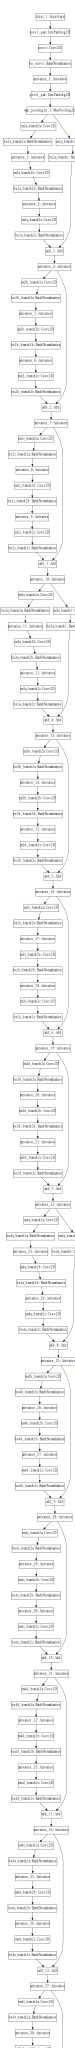

In [ ]:
plot_model(custom_resnet, to_file='model.png')
SVG(model_to_dot(custom_resnet).create(prog='dot', format='svg'))

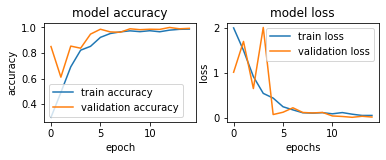

In [ ]:
import matplotlib.pyplot as plt
plt.figure(1)
plt.subplot(221)
plt.plot(train_history.history['accuracy'])
plt.plot(train_history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train accuracy','validation accuracy'])

plt.subplot(222)
plt.plot(train_history.history['loss'])
plt.plot(train_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(['train loss', 'validation loss'])

plt.show()

In [ ]:
custom_resnet.load_weights(MODEL_CHECK_WEIGHT_NAME)

In [ ]:
# training performance of the trained model
probabilities = custom_resnet.predict_generator(train_gen, len(train_gen))
print(np.shape(probabilities))

(1097, 10)


In [ ]:
prediction_label = np.argmax(probabilities, axis = 1)
print(np.shape(prediction_label))

(1097,)


In [ ]:
train_labels = train_gen.classes
print(np.shape(train_labels))

(1097,)


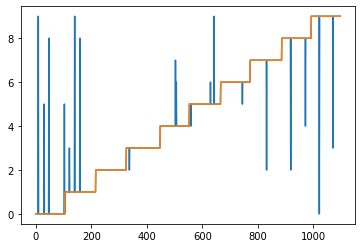

In [ ]:
plt.plot(prediction_label)
plt.plot(train_labels)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Class labels
{'n0': 0, 'n1': 1, 'n2': 2, 'n3': 3, 'n4': 4, 'n5': 5, 'n6': 6, 'n7': 7, 'n8': 8, 'n9': 9}


Training Accuracy of the model is 98.27%


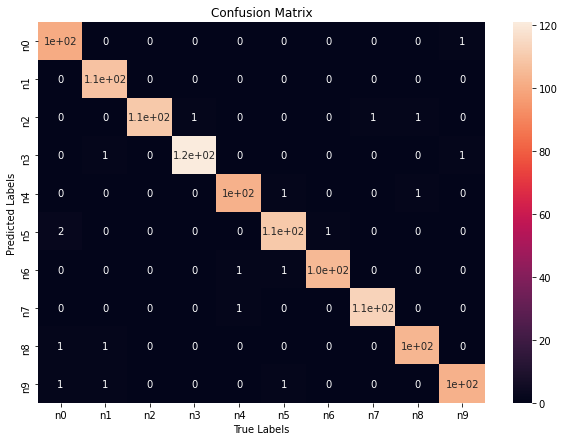

In [ ]:
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve
import seaborn as sns
import pandas as pd

print('Class labels')
print(train_gen.class_indices)

classes = train_gen.class_indices.keys()
print('\n')
#Plotting confusion matrix
cm = confusion_matrix(prediction_label, train_labels)
df_cm = pd.DataFrame(cm, index = [i for i in classes],columns = [i for i in classes])
plt.figure(figsize = (10,7))
plt.title('Confusion Matrix')


sns.heatmap(df_cm, annot=True)
plt.xlabel('True Labels')
plt.ylabel('Predicted Labels')

acc = ((prediction_label == train_labels).sum())/len(train_labels) * 100

print('Training Accuracy of the model is %.2f%%' % (acc))

In [ ]:
train_gen.class_indices

{'n0': 0,
 'n1': 1,
 'n2': 2,
 'n3': 3,
 'n4': 4,
 'n5': 5,
 'n6': 6,
 'n7': 7,
 'n8': 8,
 'n9': 9}

In [ ]:
# training performance of the validation model
probabilities = custom_resnet.predict_generator(val_gen, len(val_gen))
print(np.shape(probabilities))

(272, 10)


In [ ]:
prediction_label = np.argmax(probabilities, axis = 1)
print(np.shape(prediction_label))

(272,)


In [ ]:
val_labels = val_gen.classes
print(np.shape(val_labels))

(272,)


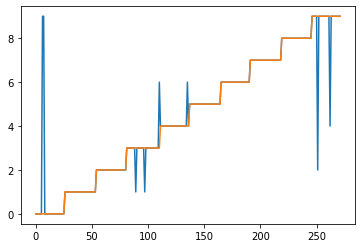

In [ ]:
plt.plot(prediction_label)
plt.plot(val_labels)

Class labels
{'n0': 0, 'n1': 1, 'n2': 2, 'n3': 3, 'n4': 4, 'n5': 5, 'n6': 6, 'n7': 7, 'n8': 8, 'n9': 9}


Training Accuracy of the model is 97.06%


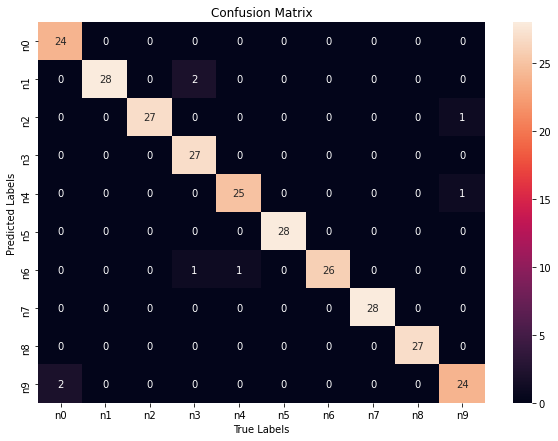

In [ ]:
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve
import seaborn as sns
import pandas as pd

print('Class labels')
print(val_gen.class_indices)

classes = val_gen.class_indices.keys()
print('\n')
#Plotting confusion matrix
cm = confusion_matrix(prediction_label, val_labels)
df_cm = pd.DataFrame(cm, index = [i for i in classes],columns = [i for i in classes])
plt.figure(figsize = (10,7))
plt.title('Confusion Matrix')


sns.heatmap(df_cm, annot=True)
plt.xlabel('True Labels')
plt.ylabel('Predicted Labels')

acc = ((prediction_label == val_labels).sum())/len(val_labels) * 100

print('Training Accuracy of the model is %.2f%%' % (acc))

The model is ~96% accurate. Now I would attempt to use this model to detect anomaly from the monkeys images.

<h1>Anomaly Detection</h1>

- Approach 1 is a hypothesis testing based approach.

In [ ]:
layer_name = 'dropout_2'
intermediate_layer_model = Model(inputs=custom_resnet.input,
                                 outputs=custom_resnet.get_layer(layer_name).output)
intermediate_output = intermediate_layer_model.predict_generator(train_gen, len(train_gen))
print(np.shape(intermediate_output))

(1097, 512)


In [ ]:
# visualizing if clustering is possible
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca_inputs = pca.fit_transform(intermediate_output)
train_labels = train_gen.classes

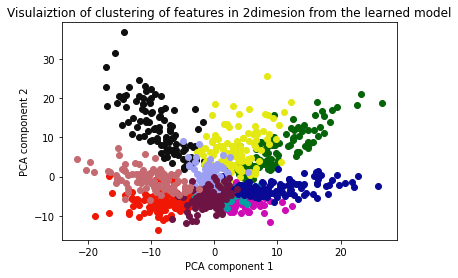

In [ ]:
cls_color = {0: '#f01805', 1: '#0f0f0f', 2: '#056308', 3: '#e4e813', 4: '#cf0cb5', 5: '#02a1a1', 6: '#080a96', 7: '#9d9ff2', 8: '#6e1445', 9: '#c46a70'}
for idx in range(len(pca_inputs)):
  plt.scatter(pca_inputs[idx, 0], pca_inputs[idx, 1], color = cls_color[train_labels[idx]])

plt.title('Visulaiztion of clustering of features in 2dimesion from the learned model')
plt.xlabel('PCA component 1')
plt.ylabel('PCA component 2')
plt.show()

Hypothesis if a point is not a part of a cluster then it must be a different from any of the class for which the model is trained. For this I will first find the means and standard deviations for the feature vectors of different classes.

In [ ]:
classes = np.unique(train_labels)

idx_cls = []
for class_ in classes:
  idx_this_cls = []
  for idx in range(len(train_labels)):
    if(train_labels[idx] == class_):
      idx_this_cls.append(idx)
  idx_cls.append(idx_this_cls)

In [ ]:
mean_clusters = [] # 10 X 512
std_clusters = [] # 10 X 512

for class_index in idx_cls:
  #class_index is a list
  v = []
  for idx in class_index:
    v.append(intermediate_output[idx])
  v = np.array(v)
  m = np.mean(v, axis=0)
  mean_clusters.append(m)
  std_clusters.append(np.std(v, axis = 0))

print(np.shape(mean_clusters))
print(np.shape(std_clusters))

(10, 512)
(10, 512)


In [ ]:
def dis(v1, v2):
  '''Returns L2 norm between two vectors'''
  dis_ = v1 - v2
  dis_tot = np.sum(dis_**2)
  return np.sqrt(dis_tot)

def dis_vec(v1, v2):
  '''Returns a vector form of distance between two vectors'''
  dis_ = v1 - v2
  dis_abs = np.abs(dis_)
  return dis_abs

In [ ]:
def closest_center(feature_vector, clusters_mean):
  ''' Finds the center closest the feature vector obtained for 
  a particular image.'''
  dis_centers = []
  for mean in clusters_mean:
    dis_centers.append(dis(mean, feature_vector))

  #print(np.shape(dis_centers))
  # closest center
  c_cen = np.argmin(dis_centers)
  #print(c_cen)
  return c_cen

def within_2sigma_c_cen(dist_mean, sigma, threshold):
  '''Finding if the vector is close to the center'''
  bool_dec = dist_mean > 2*np.sqrt(sigma)
  #print(np.sum(bool_dec))
  if(np.sum(bool_dec) < threshold):
    # is not an anomaly
    return False
  else:
    # is an anomaly
    return True

Using an anomoly like pics of different animals and verifying if its an anomaly or not

In [ ]:
def check_anomaly(img_src):
  '''Checks if an input image is anomaly or not.'''
  img = cv2.imread(img_src)
  dim = (224, 224)
  img = cv2.resize(img, dim, interpolation = cv2.INTER_AREA)
  img = img/255
  img = img.reshape(1, 224, 224, 3)
  prediction = intermediate_layer_model.predict(img)
  n_c = closest_center(prediction, mean_clusters)
  mean_c = mean_clusters[n_c]
  std_c = std_clusters[n_c]
  dist = dis_vec(i, mean_c)
  #print(dist)
  #print(std_c)
  '''plt.plot(dist)
  plt.show()
  plt.plot(2*std_c)
  plt.show()'''
  return within_2sigma_c_cen(dist, std_c, threshold = threshold)

In [ ]:
images = ['dog.jpg', 'chimpanzee.jpg', 'lioness.jpg']
for image in images:
  #print(check_anomaly(image))
  res = check_anomaly(image)
  if res == True:
    print('Image is an anomaly')
  else:
    print('Image is not an anomaly')

Image is an anomaly
Image is an anomaly
Image is an anomaly


<h1>Autoencoder Model</h1>

Building a normal auto-encoder model try and reconstruct the images of monkeys and then we can use the total reconstruction error to find the anomalies.

In [ ]:
#Using a fairly small network autoencoder network which will attempt to regenerate the original image

#Using a color image as input can reduce the complexity by taking a grey image
input_img = Input(shape=(224, 224, 3))    # adapt this if using 'channels_first' image data format

x = Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

# at this point the representation is (28, 28, 8), i.e. 6,272-dimensional

x = Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(16, (3, 3), activation='relu', padding = 'same')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')
autoencoder.summary()

Model: "model_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
conv2d_43 (Conv2D)           (None, 224, 224, 16)      448       
_________________________________________________________________
max_pooling2d_19 (MaxPooling (None, 112, 112, 16)      0         
_________________________________________________________________
conv2d_44 (Conv2D)           (None, 112, 112, 8)       1160      
_________________________________________________________________
max_pooling2d_20 (MaxPooling (None, 56, 56, 8)         0         
_________________________________________________________________
conv2d_45 (Conv2D)           (None, 56, 56, 8)         584       
_________________________________________________________________
max_pooling2d_21 (MaxPooling (None, 28, 28, 8)         0   

In [ ]:
#Read in the data
datagen = ImageDataGenerator(rescale=1./255)
train_gen = datagen.flow_from_directory(root_dir, target_size=(224,224), batch_size=32, class_mode='input', shuffle = False, classes = different_species)

Found 1097 images belonging to 10 classes.


In [ ]:
val_gen = datagen.flow_from_directory(val_dir, target_size=(224,224), batch_size=32, class_mode='input', shuffle=False, classes = different_species)

Found 272 images belonging to 10 classes.


In [ ]:
from keras.callbacks import EarlyStopping, ModelCheckpoint
PATIENCE = 5
EPOCHS = 30
MODEL_CHECK_WEIGHT_NAME = 'autoencoder_mnks.h5'

In [ ]:
es_callback = EarlyStopping(monitor ='val_loss', patience=PATIENCE, mode='auto')
mc_callback = ModelCheckpoint(filepath = MODEL_CHECK_WEIGHT_NAME, monitor='val_loss', save_best_only=True, mode='auto')
train_history = autoencoder.fit_generator(train_gen, steps_per_epoch=len(train_gen), epochs= EPOCHS, validation_data= train_gen, validation_steps= len(val_gen), verbose=1, callbacks=[es_callback, mc_callback])

Epoch 1/30
35/35 [==============================] - 104s 3s/step - loss: 0.6784 - val_loss: 0.6422
Epoch 2/30
35/35 [==============================] - 100s 3s/step - loss: 0.6241 - val_loss: 0.6142
Epoch 3/30
35/35 [==============================] - 100s 3s/step - loss: 0.6009 - val_loss: 0.5920
Epoch 4/30
35/35 [==============================] - 100s 3s/step - loss: 0.5957 - val_loss: 0.5827
Epoch 5/30
35/35 [==============================] - 101s 3s/step - loss: 0.5850 - val_loss: 0.5422
Epoch 6/30
35/35 [==============================] - 104s 3s/step - loss: 0.5804 - val_loss: 0.5738
Epoch 7/30
35/35 [==============================] - 102s 3s/step - loss: 0.5764 - val_loss: 0.5633
Epoch 8/30
35/35 [==============================] - 99s 3s/step - loss: 0.5746 - val_loss: 0.5566
Epoch 9/30
35/35 [==============================] - 103s 3s/step - loss: 0.5736 - val_loss: 0.5990
Epoch 10/30
18/35 [==============>...............] - ETA: 44s - loss: 0.5695

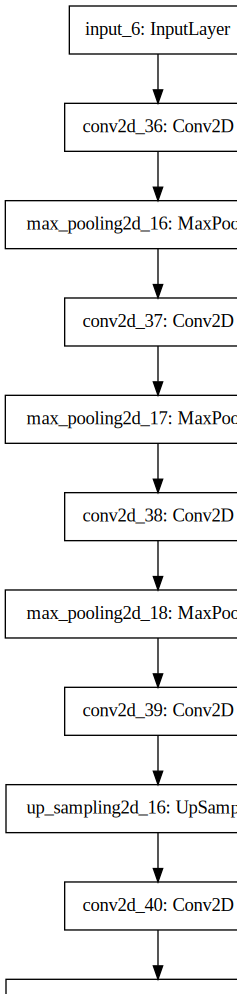

In [ ]:
plot_model(autoencoder, to_file='autoencoder_model.png')
SVG(model_to_dot(autoencoder).create(prog='dot', format='svg'))

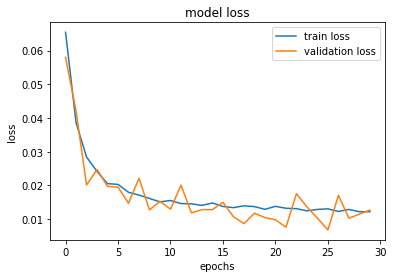

In [ ]:
plt.figure()
plt.plot(train_history.history['loss'])
plt.plot(train_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(['train loss', 'validation loss'])

plt.show()

In [ ]:
autoencoder.load_weights(MODEL_CHECK_WEIGHT_NAME)

In [ ]:
#autoencoder models are usually used to denoise an image but it can be used to generate copy of particular type of images like in this case
#the reconstruction error then becomes a parameter via which we can detect anomalies

import random
import cv2
from google.colab.patches import cv2_imshow
dir_ = val_gen.directory
names = val_gen.filenames
select_5random = random.sample(names, 5) 

Original resized image


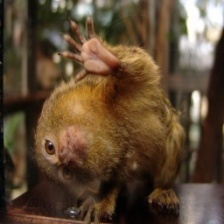

Reconstructed image


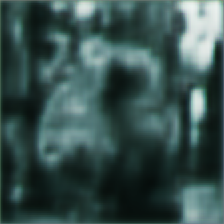

Original resized image


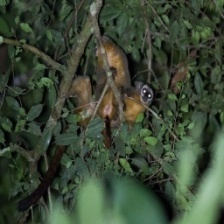

Reconstructed image


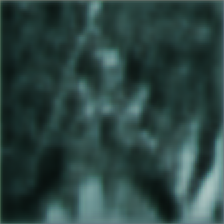

Original resized image


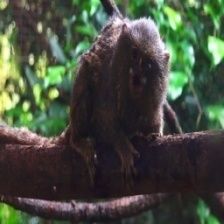

Reconstructed image


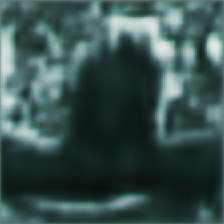

Original resized image


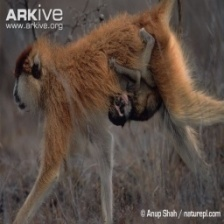

Reconstructed image


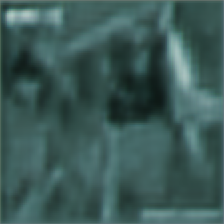

Original resized image


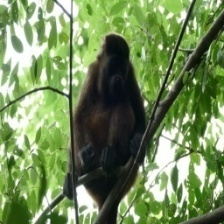

Reconstructed image


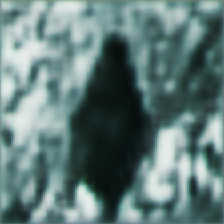

In [ ]:
for img_name in select_5random:
  img_src = os.path.join(dir_, img_name)
  img = cv2.imread(img_src)
  dim = (224, 224)
  img = cv2.resize(img, dim, interpolation = cv2.INTER_AREA)
  print('Original resized image')
  cv2_imshow(img)
  img = img/255
  img = img.reshape(1, 224, 224, 3)
  reconstructed_img = autoencoder.predict(img)
  reconstructed_img = reconstructed_img.reshape(224, 224, 3)
  reconstructed_img = reconstructed_img*255
  reconstruced_img = reconstructed_img.astype(int)
  print('Reconstructed image')
  cv2_imshow(reconstructed_img)

Original resized image


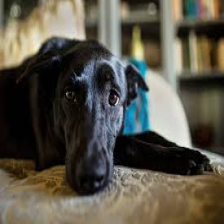

Reconstructed image


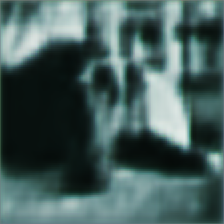

Original resized image


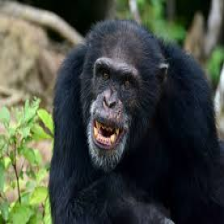

Reconstructed image


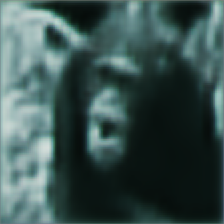

Original resized image


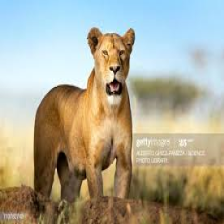

Reconstructed image


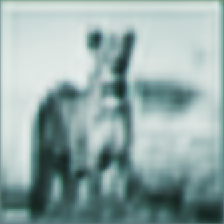

In [ ]:
#Checking the same for different images
images = ['dog.jpg', 'chimpanzee.jpg', 'lioness.jpg']
for image in images:
  img = cv2.imread(image)
  dim = (224, 224)
  img = cv2.resize(img, dim, interpolation = cv2.INTER_AREA)
  print('Original resized image')
  cv2_imshow(img)
  img = img/255
  img = img.reshape(1, 224, 224, 3)
  reconstructed_img = autoencoder.predict(img)
  reconstructed_img = reconstructed_img.reshape(224, 224, 3)
  reconstructed_img = reconstructed_img*255
  reconstruced_img = reconstructed_img.astype(int)
  print('Reconstructed image')
  cv2_imshow(reconstructed_img)

Original resized image


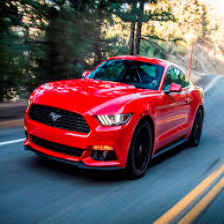

Reconstructed image


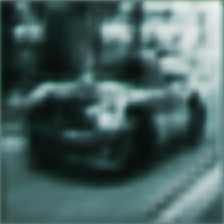

Original resized image


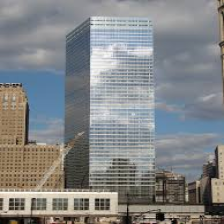

Reconstructed image


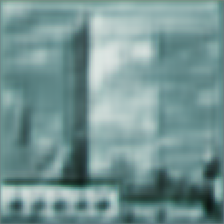

In [ ]:
#Checking the same for completely different images
images = ['car.jpg', 'building.jpg']
for image in images:
  img = cv2.imread(image)
  dim = (224, 224)
  img = cv2.resize(img, dim, interpolation = cv2.INTER_AREA)
  print('Original resized image')
  cv2_imshow(img)
  img = img/255
  img = img.reshape(1, 224, 224, 3)
  reconstructed_img = autoencoder.predict(img)
  reconstructed_img = reconstructed_img.reshape(224, 224, 3)
  reconstructed_img = reconstructed_img*255
  reconstruced_img = reconstructed_img.astype(int)
  print('Reconstructed image')
  cv2_imshow(reconstructed_img)

In [ ]:
#Checking the average reconstruction error for validation dataset
err = autoencoder.evaluate_generator(val_gen, len(val_gen))
print('Mean square reconstructed error of the model on the validation set is {}'.format(err))

Mean square reconstructed error of the model on the validation set is 0.01569441892206669


In [ ]:
for img_name in select_5random:
  img_src = os.path.join(dir_, img_name)
  img = cv2.imread(img_src)
  dim = (224, 224)
  img = cv2.resize(img, dim, interpolation = cv2.INTER_AREA)
  #print('Original resized image')
  #cv2_imshow(img)
  img_o = img/255
  img = img_o.reshape(1, 224, 224, 3)
  reconstructed_img = autoencoder.predict(img)
  reconstructed_img = reconstructed_img.reshape(224, 224, 3)
  err = (reconstruced_img - img_o)**2
  mse = np.mean(err)
  print('Reconstruction error of {} is {}'.format(image, mse))
  #reconstructed_img = reconstructed_img*255
  #reconstruced_img = reconstructed_img.astype(int)
  #print('Reconstructed image')
  #cv2_imshow(reconstructed_img)

Reconstruction error of building.jpg is 20346.512932880265
Reconstruction error of building.jpg is 20359.253049525363
Reconstruction error of building.jpg is 20348.09920679894
Reconstruction error of building.jpg is 20342.30285198944
Reconstruction error of building.jpg is 20304.150506467697


In [ ]:
#Checking the same for different images
images = ['dog.jpg', 'chimpanzee.jpg', 'lioness.jpg', 'car.jpg', 'building.jpg']
for image in images:
  img = cv2.imread(image)
  dim = (224, 224)
  img = cv2.resize(img, dim, interpolation = cv2.INTER_AREA)
  #print('Original resized image')
  #cv2_imshow(img)
  img_o = img/255
  img = img_o.reshape(1, 224, 224, 3)
  reconstructed_img = autoencoder.predict(img)
  reconstructed_img = reconstructed_img.reshape(224, 224, 3)
  err = (reconstruced_img - img_o)**2
  mse = np.mean(err)
  print('Reconstruction error of {} is {}'.format(image, mse))
  #reconstructed_img = reconstructed_img*255
  #reconstruced_img = reconstructed_img.astype(int)
  #print('Reconstructed image')
  #cv2_imshow(reconstructed_img)

Reconstruction error of dog.jpg is 20334.630946362606
Reconstruction error of chimpanzee.jpg is 20347.983139563927
Reconstruction error of lioness.jpg is 20247.67444845994
Reconstruction error of car.jpg is 20326.67237784043
Reconstruction error of building.jpg is 20272.71394297088


Models have the same reconstruction cost. Which either means that the Autoencoder model is not deep enough or maybe I need to find an alternate version of the model.